In [176]:
# 1 Filtering
import findspark
findspark.init()

import pandas as pd

# read T2
df=pd.read_csv("task3_dataset.csv")

# list the columns
list(df)

# print number of rows and columns 
print (df.shape)

# 1.1 Filter rows
# convert string to datetime
df['TimeStemp'] = pd.to_datetime(df['TimeStemp'])

#Eliminar filas con valores nulos
df.dropna()

#filter data by date
dfMondays = df[((df['TimeStemp'] > '2016-05-02 00:00:00') & (df['TimeStemp'] <= '2016-05-02 23:59:59')) | ((df['TimeStemp'] > '2016-05-9 00:00:00') & (df['TimeStemp'] <= '2016-05-9 23:59:59')) | ((df['TimeStemp'] > '2016-05-16 00:00:00') & (df['TimeStemp'] <= '2016-05-16 23:59:59'))]

# print number of rows and columns
print (dfMondays.shape)

# save data base
dfMondays.to_csv("T3_Mondays.csv", index= False)


(24518, 18)
(4086, 18)


In [177]:
#Catch training and test values from the dataset
from sklearn.model_selection import train_test_split

featuredColumns = ['GyroscopeStat_x_MEAN','GyroscopeStat_z_MEAN','GyroscopeStat_COV_z_x','GyroscopeStat_COV_z_y','MagneticField_x_MEAN','MagneticField_z_MEAN','MagneticField_COV_z_x','MagneticField_COV_z_y','Pressure_MEAN','LinearAcceleration_COV_z_x','LinearAcceleration_COV_z_y','LinearAcceleration_x_MEAN','LinearAcceleration_z_MEAN']

#HERE START NAIVE BAYES LEARNER
X = dfMondays[featuredColumns]
Y = dfMondays[['attack']]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [178]:
from sklearn.preprocessing import StandardScaler

#Normalize the data
escaler=StandardScaler()
X_train=escaler.fit_transform(X_train)
X_test=escaler.fit_transform(X_test)

In [179]:
#Define the algorithm to use
from sklearn.linear_model import LogisticRegression

algoritm=LogisticRegression(solver='lbfgs')

In [180]:
#Train the model
algoritm.fit(X_train,Y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
#Prediction
Y_pred_naive_bayes = algoritm.predict(X_test)

In [182]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test,Y_pred_naive_bayes)
print("Matriz de confusion:")
print(matrix)

Matriz de confusion:
[[818]]


In [183]:
#Precision of the algorithm
from sklearn.metrics import precision_score 

precision = precision_score(Y_test, Y_pred_naive_bayes, average='weighted', labels= pd.unique(Y_pred_naive_bayes))
print("Precision del modelo:")
print(precision)

Precision del modelo:
1.0


In [184]:
#HERE START DECISION TREE LEARNER
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

#Convert the dataframe from pandas to sql
dfMondays = sqlCtx.createDataFrame(dfMondays)

In [185]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#Merge selected columns into one
assembler = VectorAssembler(inputCols = featuredColumns, outputCol="features")
assembled = assembler.transform(dfMondays)

#Catch train and test data from chosen columns
(trainingData, testData) = assembled.randomSplit([0.8,0.2], seed=123123) 

trainingData.count(), testData.count()

(3289, 797)

In [186]:
from pyspark.ml.classification import DecisionTreeClassifier

#Start decision tree clasificator
dt = DecisionTreeClassifier(labelCol="attack", featuresCol="features", maxDepth=5, minInstancesPerNode=20, impurity="gini")

In [187]:
from pyspark.ml import Pipeline

#Normalize data
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

In [188]:
#Get predictions from the model

predictions = model.transform(testData)

In [189]:
from pyspark.sql.types import DoubleType

#Convert the attack column from int to double to prevent subsequent failure
predictions = predictions.withColumn("attack", predictions["attack"].cast("double"))

In [190]:
#Compare first 10 rows (not necesary)
predictions = predictions.select("prediction","attack")
predictions.show(10)

+----------+------+
|prediction|attack|
+----------+------+
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
|       0.0|   0.0|
+----------+------+
only showing top 10 rows



In [191]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Show success percentage of the model with the test data
evaluator = MulticlassClassificationEvaluator(labelCol="attack", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:")
print(accuracy)

Accuracy:
1.0


In [192]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictions.rdd.map(tuple))

In [193]:
#Confusion matrix from the decision tree
metrics.confusionMatrix().toArray().transpose()

array([[797.]])

In [194]:
#HERE STARTS RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 20 arboles
model = RandomForestClassifier(n_estimators=20, 
                               bootstrap = True, verbose=2,
                               max_features = 'sqrt')
# a entrenar!
model.fit(X_train, Y_train.values.ravel())

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

In [195]:
#Get predictions from the model

predictions = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [196]:
from sklearn.metrics import confusion_matrix

#Pedimos la matriz de confusión de las predicciones del grupo Test. La diagonal de esta matriz se lee: arriba a la izda True Negatives y abajo a la dcha True Positives. 
confusion_matrix(Y_test,predictions)

array([[818]])

In [197]:
from sklearn.metrics import accuracy_score

#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
accuracy_score(Y_test, predictions)

1.0

In [198]:
from sklearn.ensemble import ExtraTreesClassifier

#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

In [199]:
#Ajustamos el modelo

model.fit(X_train,Y_train)

/home/joselu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [200]:
#Pedimos que nos muestre la importancia de cada variable

print(model.feature_importances_)

[0.14774263 0.05356453 0.05732316 0.04104357 0.07096681 0.0731429
 0.04759116 0.07913638 0.09015713 0.08175713 0.16423957 0.04065326
 0.05268177]


In [201]:
#Si queremos ver todas las variables en caso de ser muchas, mejor usar el comando «list»

list(model.feature_importances_)

[0.14774263140594318,
 0.05356453050019594,
 0.05732315530292347,
 0.04104357076173389,
 0.0709668106495214,
 0.07314289543358288,
 0.04759116341969164,
 0.07913638058612121,
 0.09015713075845518,
 0.08175713232561499,
 0.16423957092160535,
 0.04065325519410685,
 0.05268177274050417]

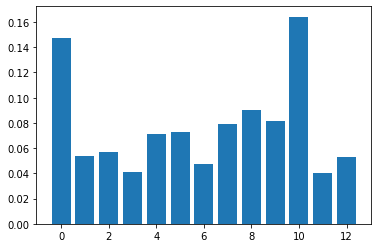

In [202]:
#Para dibujar todos las variables con su importancia

from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

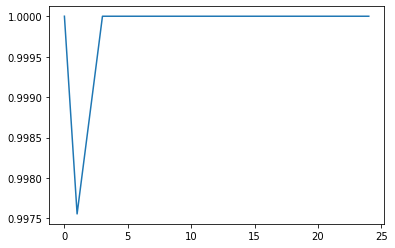

In [203]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score

#Para ver cuánto ha aportado cada nuevo árbol que hemos construido
trees=range(25)
accuracy=np.zeros(25)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx + 1)
    classifier=classifier.fit(X_train,Y_train.values.ravel())
    predictions=classifier.predict(X_test)
    accuracy[idx]=accuracy_score(Y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)